In [ ]:
import csv
import random
import os
import glob
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import conorm
import joblib
import pandas as pd
import numpy as np

In [2]:
def fetch_metaD(samplesheet_path):
    metadata = pd.read_csv(samplesheet_path, sep=",")
    metadata['basename'] = [os.path.basename(i).split("_S")[0].split("_R")[0] for i in metadata.fastq_1]
    metadata['diagnosis'] = [i.split("_")[0] for i in metadata['sample']]
    metaD = dict(zip(metadata['basename'], metadata['diagnosis']))
    return metaD

def fetch_combined_matrix(matrix_path, metaD):
    kmer_matrix = pd.read_csv(matrix_path, sep="\t", index_col=0)
    filtered_kmer_matrix = kmer_matrix[~(kmer_matrix == 0).all(axis=1)]
    print(f"Dataset of {filtered_kmer_matrix.shape[0]} kmers, {filtered_kmer_matrix.shape[1]} samples.")
    return filtered_kmer_matrix

In [ ]:
RNA_metaD = fetch_metaD("cfRNA_GBM_exomes_r2_k15/samplesheet.csv")
RNA_metaD = {k: "CONTROL" if v != "GBM" else v for k, v in RNA_metaD.items()}
DNA_metaD = fetch_metaD("cfDNA_GBM_k15/samplesheet.csv")
DNA_metaD = {k: "CONTROL" if v != "GBM" else v for k, v in DNA_metaD.items()}

RNA_df = fetch_combined_matrix("cfRNA_GBM_exomes_r2_k15/combined_counts_matrix.txt", RNA_metaD)
DNA_df = fetch_combined_matrix("cfDNA_GBM_k15/combined_counts_matrix.txt", DNA_metaD)

norm_RNA = conorm.cpm(RNA_df)
norm_DNA = conorm.cpm(DNA_df)

del(RNA_df)
del(DNA_df)

# change column names of RNA to match DNA df
norm_RNA.columns = [i.replace("RNA","") for i in norm_RNA.columns]

Dataset of 3773 kmers, 38 samples.
Dataset of 3815 kmers, 40 samples.


In [5]:
ctrls = [k for k, v in DNA_metaD.items() if v != "GBM"]
gbms = [k for k, v in DNA_metaD.items() if v == "GBM"]
gbms.remove("H35-04")
gbms.remove("H35-14")

In [6]:
Counter(RNA_metaD.values())

Counter({'GBM': 29, 'CONTROL': 9})

In [ ]:
def filter_low_high_counts(df, ctrls, lowerlim, upperlim, min_samples=8):
    master_indexes = set()
    selected_ctrls = random.sample(ctrls, 4)
    ctrl_subset = df[selected_ctrls]
    
    dna_low_features = ctrl_subset.gt(lowerlim).all(axis=1)
    low_indices = dna_low_features[dna_low_features].index
    master_indexes.update(low_indices)
    
    dna_high_features = ctrl_subset.gt(upperlim).any(axis=1)
    high_indices = dna_high_features[dna_high_features].index
    master_indexes.update(high_indices)
    
    if min_samples > 0:
        filtered_df = df.drop(index=master_indexes)
        sample_counts = (filtered_df > 0).sum(axis=1)
        features_to_keep = sample_counts[sample_counts >= min_samples].index
        
        sub_norm = filtered_df.loc[features_to_keep]
    else:
        sub_norm = df.drop(index=master_indexes)
    
    # drop the features that fails criteria
    sub_norm = df.drop(index=master_indexes)
    return sub_norm

In [ ]:
from itertools import combinations
from scipy.stats import mannwhitneyu


def create_neomer_plot_and_stats(data, metadata, title, ylabel):    
    plot_data = pd.DataFrame({
        'Sample': data.index,
        'Diagnosis': data.index.map(metadata),
        'nlm_count': data.values
    })
    
    sns.boxplot(x='Diagnosis', y='nlm_count', data=plot_data, order=['CONTROL', 'GBM'],
                showcaps=True, boxprops=dict(alpha=0.6), fliersize=0, 
                palette={'CONTROL': 'green', 'GBM': 'red'})
    
    sns.stripplot(x='Diagnosis', y='nlm_count', data=plot_data, order=['CONTROL', 'GBM'],
                 color='black', alpha=0.8, jitter=True, dodge=False)
    
    grouped = plot_data.groupby('Diagnosis')['nlm_count']
    
    plt.xlabel('')
    plt.ylabel(ylabel)
    plt.title(title)
    
    results = []
    for (cond1, data1), (cond2, data2) in combinations(grouped, 2):
        u_stat, p_val = mannwhitneyu(data1, data2, alternative='two-sided')
        results.append({
            'Condition_1': cond1, 
            'Condition_2': cond2, 
            'U_statistic': u_stat, 
            'p_value': p_val,
        })
    s
    if p_val < 0.05:
        sig_chars = '*' * sum([p_val < threshold for threshold in [0.05, 0.01, 0.001]])
        y_max = max(plot_data['nlm_count']) * 1.1
        plt.text(0.5, y_max, sig_chars, ha='center', va='bottom', fontsize=16)
    
    plt.tight_layout()
    
    return pd.DataFrame(results)


Original number of features: 3815
Final number of features: 576
Original number of features: 3773
Final number of features: 2157


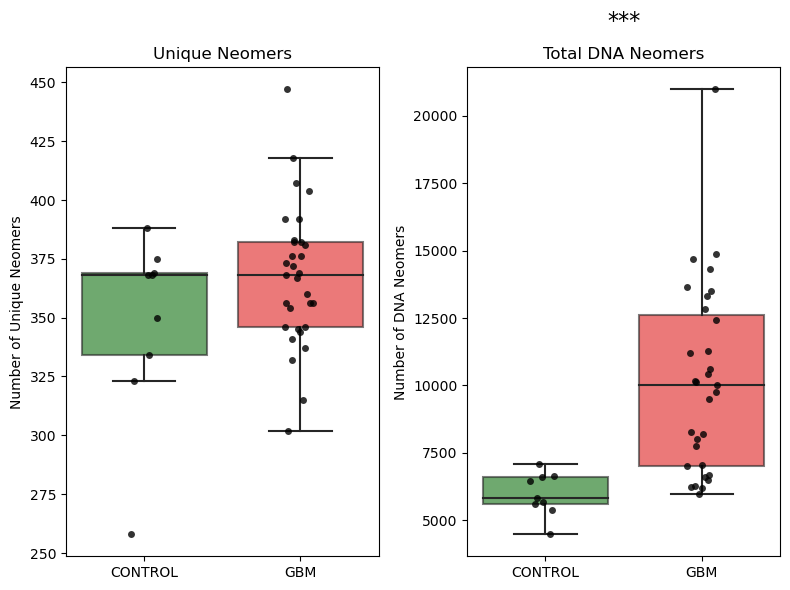


Statistics for Unique Neomers:
  Condition_1 Condition_2  U_statistic   p_value
0     CONTROL         GBM        105.5  0.277616

Statistics for Total Neomers:
  Condition_1 Condition_2  U_statistic   p_value
0     CONTROL         GBM         25.0  0.000222


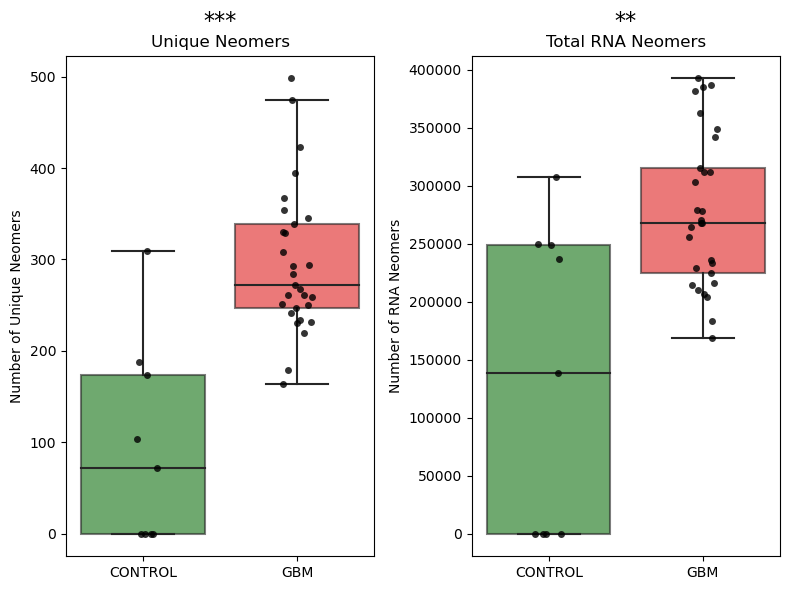


Statistics for Unique Neomers:
  Condition_1 Condition_2  U_statistic   p_value
0     CONTROL         GBM         22.0  0.000207

Statistics for Total Neomers:
  Condition_1 Condition_2  U_statistic   p_value
0     CONTROL         GBM         52.0  0.007371


In [ ]:
sub_norm_DNA = filter_low_high_counts(norm_DNA, ctrls, 0, 100)
sub_norm_RNA = filter_low_high_counts(norm_RNA, ctrls, 0, 2)

for name, dataset in {"DNA": sub_norm_DNA, "RNA": sub_norm_RNA}.items():
    plt.figure(figsize=(8, 6))
    
    plt.subplot(1, 2, 1)
    X = 0
    counts_greater_than_X = (dataset > X).sum(axis=0)
    stats1 = create_neomer_plot_and_stats(
        counts_greater_than_X, 
        DNA_metaD,
        'Unique Neomers',
        'Number of Unique Neomers'
    )
    
    plt.subplot(1, 2, 2)
    neomer_counts = dataset.sum(axis=0)
    stats2 = create_neomer_plot_and_stats(
        neomer_counts,
        DNA_metaD,
        f'Total {name} Neomers',
        f'Number of {name} Neomers'
    )
    
    plt.tight_layout()
    plt.savefig(f"neomer_boxplot_{name}.pdf", dpi=300, bbox_inches="tight")
    plt.show()
    
    print("\nStatistics for Unique Neomers:")
    print(stats1)
    print("\nStatistics for Total Neomers:")
    print(stats2)
    plt.close()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

X_rna = norm_RNA.T
X_dna = norm_DNA.T
common_samples = X_rna.index.intersection(X_dna.index)

X_rna = X_rna.loc[common_samples, ]
X_dna = X_dna.loc[common_samples, ]

if (X_rna.index == X_dna.index).all():
    print("RNA and DNA samples in same order.")
else:
    exit()

y = np.array([0 if DNA_metaD[sample] in ["CONTROL"] else 1 for sample in common_samples])
del(common_samples)

print(f"RNA: {X_rna.shape}, DNA: {X_dna.shape}")

RNA and DNA samples in same order.
RNA: (38, 3773), DNA: (38, 3815)


In [11]:
Counter(y)

Counter({1: 29, 0: 9})

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, f1_score, auc, roc_curve, average_precision_score, confusion_matrix
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingClassifier
from collections import Counter
from imblearn.over_sampling import SMOTE
import joblib
import seaborn as sns
from xgboost import callback as xcb

def plot_confusion_matrix(cm, ax):
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    cm_df = pd.DataFrame(cm, 
                        index=['Actual Negative', 'Actual Positive'],
                        columns=['Predicted Negative', 'Predicted Positive'])
    
    annot = np.empty_like(cm, dtype=object)
    for i in range(2):
        for j in range(2):
            annot[i, j] = f"{cm[i, j]}\n({cm_norm[i, j]:.1%})"
    
    sns.heatmap(cm_df, annot=annot, fmt='', cmap='Blues', ax=ax,
               cbar=True, cbar_kws={'label': 'Count'}, vmin=0)
    
    tn, fp, fn, tp = cm.ravel()
    total = cm.sum()
    accuracy = (tp + tn) / total
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    metrics_text = f"Accuracy: {accuracy:.2f} | Sensitivity: {sensitivity:.2f} | Specificity: {specificity:.2f}"
    ax.text(0.5, -0.15, metrics_text, ha='center', fontsize=10, transform=ax.transAxes)

def plot_metrics_summary(ax, results_df):
    ax.axis('off')
    
    metrics = {
        'ROC-AUC': (results_df['stack_roc_auc'].mean(), results_df['stack_roc_auc'].std()),
        'PR-AUC': (results_df['stack_pr_auc'].mean(), results_df['stack_pr_auc'].std()),
        'F1': (results_df['stack_f1'].mean(), results_df['stack_f1'].std()),
        'Sensitivity': (results_df['sensitivity'].mean(), results_df['sensitivity'].std()),
        'Specificity': (results_df['specificity'].mean(), results_df['specificity'].std())
    }
    
    info_text = "Summary Metrics:\n\n"
    for metric, (mean, std) in metrics.items():
        info_text += f"{metric}: {mean:.3f} ± {std:.3f}\n"
    
    mean_threshold = results_df['best_threshold'].mean()
    info_text += f"\nMean Best Threshold: {mean_threshold:.3f}\n"
    
    info_text += f"\nTotal Samples per Class:\n"
    info_text += f"Positive: {int(np.sum(results_df['tp'] + results_df['fn']) / len(results_df))}\n"
    info_text += f"Negative: {int(np.sum(results_df['tn'] + results_df['fp']) / len(results_df))}"
    
    ax.text(0.05, 0.95, info_text, fontsize=12, va='top')
    
    ax.set_title('Performance Metrics Summary', fontsize=14)

def plot_roc_curves_sklearn(ax, curve_data):
    for i, (y_true, y_prob) in enumerate(zip(curve_data['y_true'], curve_data['y_prob']), 1):
        RocCurveDisplay.from_predictions(
            y_true, 
            y_prob,
            name=f"Fold {i}",
            alpha=0.3,
            color='r',
            ax=ax
        )
    
    if len(curve_data['y_true']) > 1:
        all_y_true = np.concatenate(curve_data['y_true'])
        all_y_prob = np.concatenate(curve_data['y_prob'])
        
        RocCurveDisplay.from_predictions(
            all_y_true, 
            all_y_prob,
            name="Mean ROC",
            alpha=0.8,
            color='b',
            linewidth=2,
            ax=ax
        )
    
    ax.plot([0, 1], [0, 1], 'k--', label='Chance')
    
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title('ROC Curves', fontsize=14)
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(alpha=0.3)

def plot_pr_curves_sklearn(ax, curve_data):
    baselines = []
    
    for i, (y_true, y_prob) in enumerate(zip(curve_data['y_true'], curve_data['y_prob']), 1):
        baseline = np.mean(y_true)
        baselines.append(baseline)
        
        PrecisionRecallDisplay.from_predictions(
            y_true, 
            y_prob,
            name=f"Fold {i}",
            alpha=0.3,
            color='r',
            ax=ax
        )
    
    if len(curve_data['y_true']) > 1:
        all_y_true = np.concatenate(curve_data['y_true'])
        all_y_prob = np.concatenate(curve_data['y_prob'])
        
        PrecisionRecallDisplay.from_predictions(
            all_y_true, 
            all_y_prob,
            name="Mean PR",
            alpha=0.8,
            color='b',
            linewidth=2,
            ax=ax
        )
    
    mean_baseline = np.mean(baselines)
    ax.axhline(y=mean_baseline, color='k', linestyle='--', 
              label=f'Baseline ({mean_baseline:.2f})')
    
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title('Precision-Recall Curves', fontsize=14)
    ax.legend(loc='best', fontsize=10)
    ax.grid(alpha=0.3)

def plot_performance(results_df, curve_data, cm):
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    plot_roc_curves_sklearn(axes[0, 0], curve_data)
    plot_pr_curves_sklearn(axes[0, 1], curve_data)
    plot_metrics_summary(axes[1, 0], results_df)
    plot_confusion_matrix(cm, axes[1, 1])
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return fig

Number of controls in training set: 7
Fold 1:
  RNA: Removed 49 features that were > 0 in all control samples
  RNA: Removed 471 features that exceeded the upper limit of 20
  DNA: Removed 3035 features that were > 0 in all control samples
  DNA: Removed 948 features that exceeded the upper limit of 500
  Remaining features - RNA: 3302, DNA: 780
  Best threshold: 0.50, Best F1: 1.0000
Number of controls in training set: 7
Fold 2:
  RNA: Removed 46 features that were > 0 in all control samples
  RNA: Removed 471 features that exceeded the upper limit of 20
  DNA: Removed 3014 features that were > 0 in all control samples
  DNA: Removed 950 features that exceeded the upper limit of 500
  Remaining features - RNA: 3302, DNA: 801
  Best threshold: 0.10, Best F1: 0.8571
Number of controls in training set: 7
Fold 3:
  RNA: Removed 51 features that were > 0 in all control samples
  RNA: Removed 403 features that exceeded the upper limit of 20
  DNA: Removed 3058 features that were > 0 in all 

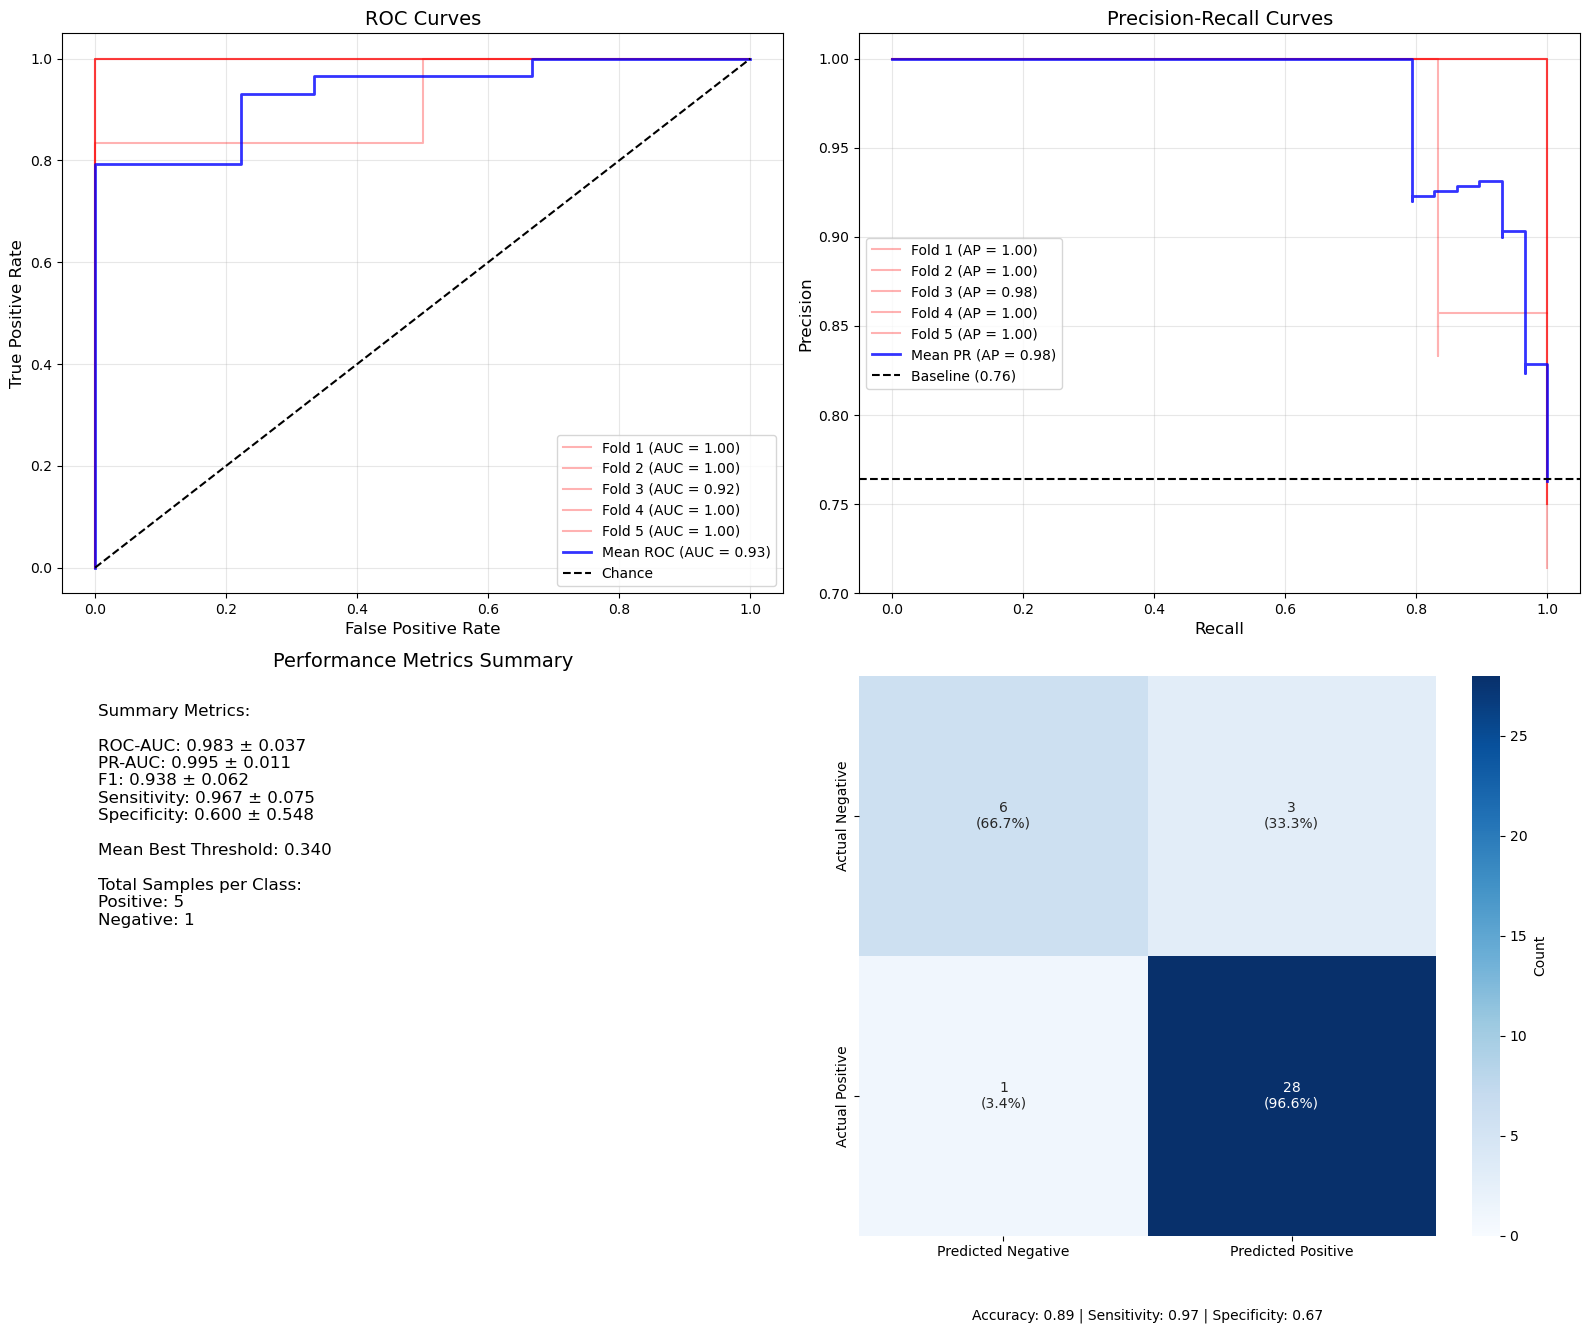

In [ ]:
def train_and_evaluate():
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    dna_upperlim = 500
    rna_upperlim = 20

    fold_results = []
    
    inner_cv = 3
    
    curve_data = {
        'y_true': [],
        'y_prob': []
    }
    
    all_true_labels = []
    all_predicted_labels = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_rna, y), 1):
        X_rna_train, X_rna_val = X_rna.iloc[train_idx], X_rna.iloc[val_idx]
        X_dna_train, X_dna_val = X_dna.iloc[train_idx], X_dna.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        print(f"Number of controls in training set: {len([c for c in y_train if c == 0])}")
        
        control_mask = y_train == 0
        
        rna_control_samples = X_rna_train[control_mask]
        rna_always_expressed = (rna_control_samples > 0).all()
        
        rna_exceeds_limit = (rna_control_samples > rna_upperlim).mean() > 0.4
        
        rna_features_to_keep = ~(rna_always_expressed | rna_exceeds_limit)
        
        dna_control_samples = X_dna_train[control_mask]
        dna_always_expressed = (dna_control_samples > 0).all()
        
        dna_exceeds_limit = (dna_control_samples > dna_upperlim).any()
        
        dna_features_to_keep = ~(dna_always_expressed | dna_exceeds_limit)
        
        X_rna_train = X_rna_train.loc[:, rna_features_to_keep]
        X_rna_val = X_rna_val.loc[:, rna_features_to_keep]
        
        X_dna_train = X_dna_train.loc[:, dna_features_to_keep]
        X_dna_val = X_dna_val.loc[:, dna_features_to_keep]

        n_rna_always_expressed = sum(rna_always_expressed)
        n_rna_exceeds_limit = sum(rna_exceeds_limit)
        n_dna_always_expressed = sum(dna_always_expressed)
        n_dna_exceeds_limit = sum(dna_exceeds_limit)
        
        scaler_rna, scaler_dna = MaxAbsScaler(), StandardScaler()
        X_rna_train_scaled = scaler_rna.fit_transform(X_rna_train)
        X_rna_val_scaled = scaler_rna.transform(X_rna_val)
        X_dna_train_scaled = scaler_dna.fit_transform(X_dna_train)
        X_dna_val_scaled = scaler_dna.transform(X_dna_val)
        
        X_rna_train_inner, X_rna_valid_inner, X_dna_train_inner, X_dna_valid_inner, y_train_inner, y_valid_inner = train_test_split(
                                    X_rna_train_scaled,
                                    X_dna_train_scaled,
                                    y_train,
                                    test_size=0.1,
                                    random_state=42,
                                    stratify=y_train)
        
        if sum(y_train == 0) >= 3:  # only if there's enough control samples
            sampling_ratio = min(1.0, sum(y_train == 1) / sum(y_train == 0)) 
            n_control_samples = min(10, int(sum(y_train == 0) * sampling_ratio))
            
            smote = SMOTE(
                sampling_strategy={0: n_control_samples},
                k_neighbors=min(3, sum(y_train == 0) - 1),
                random_state=42
            )
            X_rna_train_smote, y_train_smote = smote.fit_resample(X_rna_train_inner, y_train_inner)
            X_dna_train_smote, _ = smote.fit_resample(X_dna_train_inner, y_train_inner)
        else:
            X_rna_train_smote, y_train_smote = X_rna_train_inner, y_train_inner
            X_dna_train_smote = X_dna_train_inner

        lr_rna = LogisticRegression(
            penalty='l1',
            solver='liblinear',
            C=0.05,
            class_weight='balanced',
            max_iter=5000,
            random_state=42
        )
        
        xgb_rna = XGBClassifier(
            n_estimators=500, 
            learning_rate=0.005,
            max_depth=2,
            subsample=0.5,
            colsample_bytree=0.6,
            reg_alpha=10.0,
            reg_lambda=20.0,
            gamma=1.0,
            min_child_weight=3,
            random_state=42
        )
        
        rf_dna = RandomForestClassifier(
            n_estimators=300,
            min_samples_leaf=5,
            min_samples_split=10,
            max_features='sqrt',
            max_depth=10,
            bootstrap=True,
            random_state=42
        )
        
        xgb_dna = XGBClassifier(
            n_estimators=300,
            learning_rate=0.01,
            max_depth=4,
            min_child_weight=3,
            subsample=0.6,
            colsample_bytree=0.6,
            reg_alpha=5.0,
            reg_lambda=10.0,
            gamma=0.5,
            random_state=42
        )
        
        eval_set_rna = [(X_rna_valid_inner, y_valid_inner)]
        eval_set_dna = [(X_dna_valid_inner, y_valid_inner)]
        
        xgb_rna.fit(X_rna_train_smote, y_train_smote, verbose=0)
        xgb_dna.fit(X_dna_train_smote, y_train_smote, verbose=0)
        lr_rna.fit(X_rna_train_smote, y_train_smote)
        rf_dna.fit(X_dna_train_smote, y_train_smote)
        
        estimators = [
            ('lr_rna', lr_rna),
            ('xgb_rna', xgb_rna),
            ('rf_dna', rf_dna),
            ('xgb_dna', xgb_dna)
        ]
        
        stack = StackingClassifier(
            estimators=estimators,
            final_estimator=LogisticRegression(
                penalty='l2',
                C=0.1,
                class_weight='balanced',
                max_iter=2000,
                random_state=42
            ),
            cv=inner_cv,
            n_jobs=-1
        )
        
        X_rna_train_full = np.vstack((X_rna_train_inner, X_rna_valid_inner))
        X_dna_train_full = np.vstack((X_dna_train_inner, X_dna_valid_inner))
        y_train_full = np.concatenate((y_train_inner, y_valid_inner))
        
        X_train_combined = np.hstack((X_rna_train_full, X_dna_train_full))
        X_val_combined = np.hstack((X_rna_val_scaled, X_dna_val_scaled))
        
        stack.fit(X_train_combined, y_train_full)
        
        stack_probs = stack.predict_proba(X_val_combined)[:, 1]
        
        curve_data['y_true'].append(y_val)
        curve_data['y_prob'].append(stack_probs)
        
        fpr_stack, tpr_stack, _ = roc_curve(y_val, stack_probs)
        precision_stack, recall_stack, _ = precision_recall_curve(y_val, stack_probs)
        
        stack_roc_auc = auc(fpr_stack, tpr_stack)
        stack_pr_auc = average_precision_score(y_val, stack_probs)
        
        thresholds = np.linspace(0.1, 0.9, 9)
        f1_scores = []
        
        for thresh in thresholds:
            stack_preds = (stack_probs > thresh).astype(int)
            f1 = f1_score(y_val, stack_preds)
            f1_scores.append(f1)
        
        best_threshold = thresholds[np.argmax(f1_scores)]
        best_f1 = max(f1_scores)
        
        stack_preds = (stack_probs > best_threshold).astype(int)
        stack_f1 = f1_score(y_val, stack_preds)
        
        cm = confusion_matrix(y_val, stack_preds)
        
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        all_true_labels.extend(y_val)
        all_predicted_labels.extend(stack_preds)
        
        fold_results.append({
            'fold': fold,
            'stack_roc_auc': stack_roc_auc,
            'stack_pr_auc': stack_pr_auc,
            'stack_f1': stack_f1,
            'best_threshold': best_threshold,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'tn': tn,
            'fp': fp,
            'fn': fn, 
            'tp': tp
        })

    agg_cm = confusion_matrix(all_true_labels, all_predicted_labels)
    
    results_df = pd.DataFrame(fold_results)
    
    performance_fig = plot_performance(results_df, curve_data, agg_cm)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    # plt.savefig('glioblastoma_performance.pdf')
    plt.show()
    
    return results_df, curve_data, agg_cm

results_df, curve_data, agg_cm = train_and_evaluate()